## Targeting Multicollinearity With Python

- https://towardsdatascience.com/targeting-multicollinearity-with-python-3bd3b4088d0b

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [2]:
df = pd.read_csv("../data/car_sales/Car_sales.csv")
df.head()

,Manufacturer,Model,Sales_in_thousands,__year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
0,Acura,Integra,16.919,16.360,Passenger,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2/2/2012,58.280150
1,Acura,TL,39.384,19.875,Passenger,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,6/3/2011,91.370778
2,Acura,CL,14.114,18.225,Passenger,NaN,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,1/4/2012,NaN
3,Acura,RL,8.588,29.725,Passenger,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,3/10/2011,91.389779
4,Audi,A4,20.397,22.255,Passenger,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,10/8/2011,62.777639


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Manufacturer         157 non-null    object 
 1   Model                157 non-null    object 
 2   Sales_in_thousands   157 non-null    float64
 3   __year_resale_value  121 non-null    float64
 4   Vehicle_type         157 non-null    object 
 5   Price_in_thousands   155 non-null    float64
 6   Engine_size          156 non-null    float64
 7   Horsepower           156 non-null    float64
 8   Wheelbase            156 non-null    float64
 9   Width                156 non-null    float64
 10  Length               156 non-null    float64
 11  Curb_weight          155 non-null    float64
 12  Fuel_capacity        156 non-null    float64
 13  Fuel_efficiency      154 non-null    float64
 14  Latest_Launch        157 non-null    object 
 15  Power_perf_factor    155 non-null    flo

상관도 계산

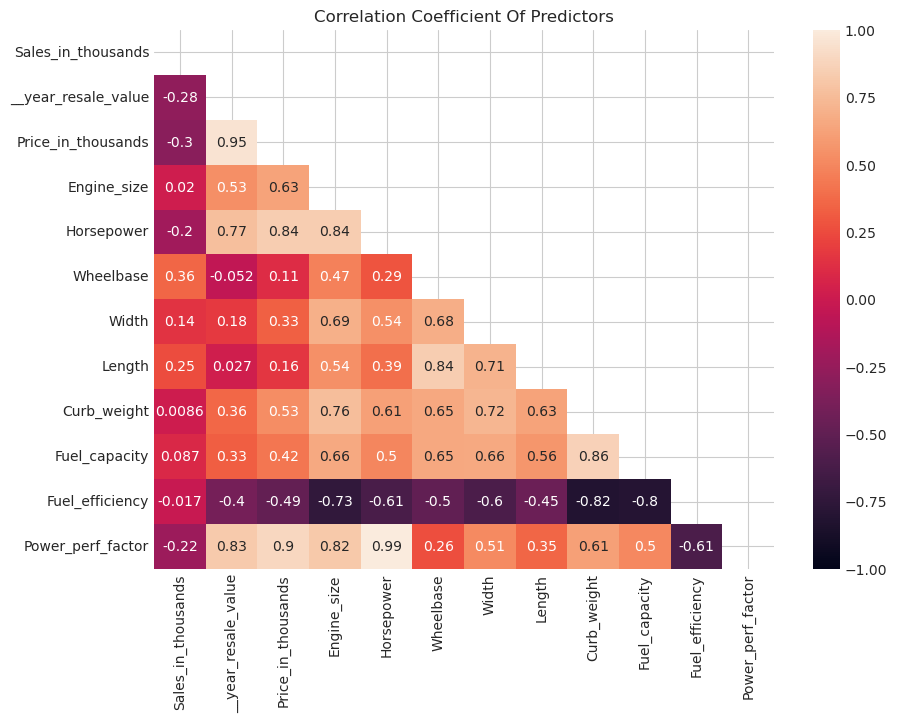

In [4]:
# set figure size
plt.figure(figsize=(10,7))

# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(df.corr(), dtype=bool))

# generate heatmap
sns.heatmap(df.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.show()

다음 피처에 높은 상관성  
- Power_perf_factor and Horsepower
- Fuel_efficiency and Engine_size
- Fuel_efficiency and Curb_weight
- Fuel_efficiency and Fuel_capacity

### Computing the VIF

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [6]:
def compute_vif(considered_features):
    
    X = df[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    X = X.dropna()
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [7]:
# features to consider removing
considered_features = ['Fuel_efficiency', 'Power_perf_factor', 'Engine_size', 'Horsepower', 'Fuel_capacity', 'Curb_weight']

# compute vif 
compute_vif(considered_features).sort_values('VIF', ascending=False)

,Variable,VIF
3,Horsepower,90.075189
1,Power_perf_factor,80.453249
5,Curb_weight,5.793651
2,Engine_size,5.694247
4,Fuel_capacity,4.543259
0,Fuel_efficiency,3.820887


‘Horsepower’, ‘Power_perf_factor’, ‘Engine_size’, and ‘Curb_weight’가 이상이다.  


가장 큰 값만 제거하고 더시 계산한다.

In [8]:
# compute vif values after removing a feature
considered_features.remove('Horsepower')
compute_vif(considered_features)

,Variable,VIF
0,Fuel_efficiency,3.797614
1,Power_perf_factor,3.057354
2,Engine_size,4.653455
3,Fuel_capacity,4.538284
4,Curb_weight,5.608859


curb_weight 제거

In [9]:
# compute vif values after removing a feature
considered_features.remove('Curb_weight')
compute_vif(considered_features)

,Variable,VIF
0,Fuel_efficiency,3.562429
1,Power_perf_factor,3.093985
2,Engine_size,4.397301
3,Fuel_capacity,2.946644


### Impact on predictive performance

이제 전체 피처와 일부를 비교해보자.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression


In [11]:
df = df.dropna()
df.isnull().sum()

Manufacturer           0
Model                  0
Sales_in_thousands     0
__year_resale_value    0
Vehicle_type           0
Price_in_thousands     0
Engine_size            0
Horsepower             0
Wheelbase              0
Width                  0
Length                 0
Curb_weight            0
Fuel_capacity          0
Fuel_efficiency        0
Latest_Launch          0
Power_perf_factor      0
dtype: int64

In [12]:
# find all categorical features
cat_var = [var for var in df.columns if df[var].dtypes=='object']

# one hot-encode all categorical features 
ohe = pd.get_dummies(df[cat_var])

#  dataframe with removed features
df_fs = df.drop(['Horsepower', 'Engine_size'], axis = 1)
df_fs = pd.concat([df_fs, ohe], axis=1)
df_fs = df_fs.drop(cat_var, axis=1)

# dataframe without removed features
df = pd.concat([df, ohe], axis=1)
df = df.drop(cat_var, axis=1)

# train test split for both datasets 

X = df.drop('Price_in_thousands', axis=1)
y = df['Price_in_thousands']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_fs = df_fs.drop('Price_in_thousands', axis=1)
y_fs = df_fs['Price_in_thousands']

X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(X_fs, y_fs, test_size=0.25, random_state=42)

# Standardization for both datasets 

mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

mms_fs = MinMaxScaler()
X_train_fs = mms_fs.fit_transform(X_train_fs)
X_test_fs = mms_fs.transform(X_test_fs)

# making predictions with models for both datasets

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

lr_fs = LinearRegression()
lr_fs.fit(X_train_fs, y_train_fs)
y_pred_fs = lr_fs.predict(X_test_fs)

In [13]:
# load library
from sklearn.metrics import mean_squared_error

# compute mean_squared errors for both models
mse = mean_squared_error(y_test, y_pred)
mse_fs = mean_squared_error(y_test_fs, y_pred_fs)

print('Mean squared error without feature selection: {}'.format(np.round(mse,2)))
print('Mean squared error with feature selection: {}'.format(np.round(mse_fs,2)))

Mean squared error without feature selection: 6.13
Mean squared error with feature selection: 8.88


- 성능이 약간 저하되었다.

### Impact on feature evaluation

In [14]:
# find coefficients of each feature in the data without feature selection
importance = lr.coef_
dict_importance = {X.columns[i]:importance[i] for i in range(len(X.columns))}

# find coefficients of each feature in the data with feature selection
importance_fs = lr_fs.coef_
dict_importance_fs = {X_fs.columns[i]:importance_fs[i] for i in range(len(X_fs.columns))}

# features to assess
features = ['__year_resale_value',
        'Wheelbase', 'Width', 'Length', 'Curb_weight',
       'Fuel_capacity', 'Fuel_efficiency']
feature_importance = [dict_importance[feature] for feature in features]
feature_importance_fs = [dict_importance_fs[feature] for feature in features]

# tabulate the coefficient values of each feature with and without feature selection
importance = pd.DataFrame()
importance['Feature'] = features
importance['Feature Importance (Without Feature Selection)'] = feature_importance
importance['Feature Importance (With Feature Selection)'] = feature_importance_fs
importance

,Feature,Feature Importance (Without Feature Selection),Feature Importance (With Feature Selection)
0,__year_resale_value,20.224851,20.722759
1,Wheelbase,-7.073195,-1.986082
2,Width,-3.159040,2.265797
3,Length,-1.148073,-2.492187
4,Curb_weight,10.217782,5.351667
5,Fuel_capacity,3.627671,4.456724
6,Fuel_efficiency,-0.681040,-4.734741


- As you can see from the table, removing the 2 features lead to a large change in feature importance scores for some of the variables.